# Headphones V2 - Evaluation

In [1]:
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
from scipy.integrate import simpson
import matplotlib.pyplot as plt
import os, glob, re
from pathlib import Path
from datetime import timedelta, datetime
import neurokit2 as nk
from asrpy import ASR
from scipy.signal import spectrogram
import flows
import warnings

# settings to display all columns
pd.set_option("display.max_columns", None)
# Set the number of rows to display
# pd.set_option('display.max_rows', 50)  # Show up to 100 rows

# General file locations
main_folder = "../Data/"

# Session Overview

In [2]:
# Loading the manually created mapping file
sessions = pd.read_csv(main_folder+"processed/session_overview.csv")
sessions.head(10)

,Session,ID,Config,Folder,Run,Rec_folder
0,2025-07-04-01,bk7zlu,Ear Only,GelledEarOnly/2025-07-04/bk7zlu/,rec1,GelledEarOnly/2025-07-04/bk7zlu/rec1/
1,2025-07-04-01,bk7zlu,Ear Only,GelledEarOnly/2025-07-04/bk7zlu/,rec2,GelledEarOnly/2025-07-04/bk7zlu/rec2/
2,2025-07-04-01,bk7zlu,Ear Only,GelledEarOnly/2025-07-04/bk7zlu/,rec3,GelledEarOnly/2025-07-04/bk7zlu/rec3/
3,2025-07-04-01,aq9b9k,Top+Ears,DryWithHeadband/2025-07-04/aq9b9k/,rec1,DryWithHeadband/2025-07-04/aq9b9k/rec1/
4,2025-07-04-01,aq9b9k,Top+Ears,DryWithHeadband/2025-07-04/aq9b9k/,rec2,DryWithHeadband/2025-07-04/aq9b9k/rec2/
5,2025-07-04-01,aq9b9k,Top+Ears,DryWithHeadband/2025-07-04/aq9b9k/,rec3,DryWithHeadband/2025-07-04/aq9b9k/rec3/
6,2025-07-14-01,fqzqgz,Top+Ears,DryWithHeadband/2025-07-14/fqzqgz/,rec1,DryWithHeadband/2025-07-14/fqzqgz/rec1/
7,2025-07-14-01,fqzqgz,Top+Ears,DryWithHeadband/2025-07-14/fqzqgz/,rec2,DryWithHeadband/2025-07-14/fqzqgz/rec2/
8,2025-07-14-01,fqzqgz,Top+Ears,DryWithHeadband/2025-07-14/fqzqgz/,rec3,DryWithHeadband/2025-07-14/fqzqgz/rec3/
9,2025-07-14-02,7dr6p8,Top+Ears,DryWithHeadband/2025-07-14/7dr6p8/,rec1,DryWithHeadband/2025-07-14/7dr6p8/rec1/


# oTree Logs & Functions

In [3]:
# Load otree log for last sessions
otree_df = pd.read_csv(main_folder + "processed/otree_logs.csv")
otree_df.head(3)

,participant.code,participant._index_in_pages,participant._max_page_index,participant.time_started_utc,participant.token,session.config.name,setup.1.player.headset_color,setup.1.player.token,introduction.1.player.handedness,introduction.1.player.english,introduction.1.player.multilingual,introduction.1.player.age,introduction.1.player.gender,introduction.1.player.glasses,introduction.1.player.eye_sight,introduction.1.player.color_sight,introduction.1.player.hearing,introduction.1.player.occupation,introduction.1.player.education_level,introduction.1.player.headsize,introduction.1.player.weight,introduction.1.player.height,introduction.1.player.hair_style_top,introduction.1.player.hair_style_ears,introduction.1.player.hair_type,introduction.1.player.hair_density,introduction.1.player.beard_style,introduction.1.player.hair_products,introduction.1.player.skin_oily_dry_1,introduction.1.player.skin_oily_dry_2,introduction.1.player.skin_resistant_sensitive_1,introduction.1.player.skin_resistant_sensitive_2,introduction.1.player.skin_products,introduction.1.player.time_since_meal,introduction.1.player.time_since_hydration,introduction.1.player.time_since_caffeine,introduction.1.player.time_since_nicotine,introduction.1.player.time_since_alcohol,introduction.1.player.flow_trait_single,introduction.1.player.flow_trait_sfds1,introduction.1.player.flow_trait_sfds2,introduction.1.player.flow_trait_sfds3,introduction.1.player.flow_trait_sfds4,introduction.1.player.flow_trait_sfds5,introduction.1.player.flow_trait_sfds6,introduction.1.player.flow_trait_sfds7,introduction.1.player.flow_trait_sfds8,introduction.1.player.flow_trait_sfds9,introduction.1.player.flow_trait_sfds10,introduction.1.player.rcsq_sleep,headphones_setup_1.1.player.ux_comfort,headphones_setup_1.1.player.ux_speed,headphones_setup_1.1.player.ux_ease,headphones_setup_1.1.player.ux_look,headphones_setup_1.1.player.wx_public,headphones_setup_1.1.player.wx_private,headphones_setup_1.1.player.wx_conversation,headphones_setup_1.1.player.wx_others,headphones_setup_1.1.player.tlx_single,headphones_setup_1.1.player.sus_01,headphones_setup_1.1.player.sus_02,headphones_setup_1.1.player.sus_03,headphones_setup_1.1.player.sus_04,headphones_setup_1.1.player.sus_05,headphones_setup_1.1.player.sus_06,headphones_setup_1.1.player.sus_07,headphones_setup_1.1.player.sus_08,headphones_setup_1.1.player.sus_09,headphones_setup_1.1.player.sus_10,headphones_setup_1.1.player.mr_mood,headphones_setup_1.1.player.mr_sleepy,headphones_setup_1.1.player.mr_motivy,headphones_setup_1.1.player.mf_single,headphones_setup_1.1.player.mf_01,headphones_setup_1.1.player.mf_02,headphones_setup_1.1.player.mf_03,headphones_setup_1.1.player.mf_04,headphones_setup_1.1.player.rest_actions_eo,headphones_setup_1.1.player.rest_actions_ec,headphones_setup_1.1.subsession.round_number,mathTask_1.1.player.fss06,mathTask_1.1.player.fss08,mathTask_1.1.player.fss09,mathTask_1.1.player.tlx_single,mathTask_1.1.player.difficulty,mathTask_1.1.player.mr_mood,mathTask_1.1.player.mr_sleepy,mathTask_1.1.player.mr_motivy,mathTask_1.1.player.mf_single,mathTask_1.1.player.math_actions,mathTask_1.1.subsession.round_number,mathTask_1.2.player.fss06,mathTask_1.2.player.fss08,mathTask_1.2.player.fss09,mathTask_1.2.player.tlx_single,mathTask_1.2.player.difficulty,mathTask_1.2.player.mr_mood,mathTask_1.2.player.mr_sleepy,mathTask_1.2.player.mr_motivy,mathTask_1.2.player.mf_single,mathTask_1.2.player.math_actions,mathTask_1.2.subsession.round_number,mathTask_1.3.player.fss06,mathTask_1.3.player.fss08,mathTask_1.3.player.fss09,mathTask_1.3.player.tlx_single,mathTask_1.3.player.difficulty,mathTask_1.3.player.mr_mood,mathTask_1.3.player.mr_sleepy,mathTask_1.3.player.mr_motivy,mathTask_1.3.player.mf_single,mathTask_1.3.player.math_actions,mathTask_1.3.subsession.round_number,mathTask_1.4.player.fss06,mathTask_1.4.player.fss08,mathTask_1.4.player.fss09,mathTask_1.4.player.tlx_single,mathTask_1.4.player.difficulty,mathTask_1.4.player.mr_mood,mathTask_1.

In [4]:
# Extract client side timestamps from dedicated otree log columns
def get_actionlog_times(logs_df):
    # Get the timestamps from logging fields
    timestamps = logs_df.filter(regex='actions').dropna(axis=1, how='all').reset_index(drop=True)
    # display(timestamps)
    
    def extract_times(s):
        s = s[0].split(';') # Split string
        s = s[1:] # Remove first, empty entry
        # print(s)

        # Convert into DataFrame
        n_messages = int(len(s)/3)
        messages = []
        ts = []
        ts_unix = []
        for i in range(0, n_messages):
            step = i*3
            messages.append(s[step])
            ts.append(s[step+1])
            ts_unix.append(s[step+2])

        df = pd.DataFrame({'Message':messages, 
                           'TS':ts,
                           'TS_UNIX':ts_unix})

        # Convert unix timestamp to correct datetime
        df['TS'] = pd.to_datetime(pd.to_numeric(df['TS_UNIX'], errors='coerce'), unit='ms', utc=True).dt.tz_convert('Europe/Berlin')
        # print(df.Message.unique())

        return df

    # Parse TS cols
    # TODO: This code could be nicer using a split-apply-combine logic...
    timestamps_parsed = pd.DataFrame()
    for phase in timestamps.columns:
        msgs = extract_times(timestamps[phase])
        msgs['Exp_Phase'] = phase.replace('xTS', '')
        timestamps_parsed = pd.concat([timestamps_parsed, msgs], ignore_index=True) # Had to change this as append is deprecated in pandas since 2.0 -> Alternatively: versioning in requirements.txt 

        
    # Remove unnecessary events
    timestamps_parsed = timestamps_parsed[timestamps_parsed.Message.str.contains("taskStart|taskEnd")]
    # display(timestamps_parsed)
    # display(timestamps_parsed['Exp_Phase'].value_counts())
    
    # Restructure DF
    timestamps_parsed.drop(['TS_UNIX'], axis=1, inplace=True)
    timestamps_parsed['Message'] = timestamps_parsed['Message'].str.replace('task', '', regex=False) # Remove the substring "task"
    timestamps_parsed = timestamps_parsed.pivot(index='Exp_Phase', columns='Message', values='TS').reset_index() # Pivot the DataFrame
    
    timestamps_parsed[['app_name', 'round_number', 'player', 'page_name']] = timestamps_parsed['Exp_Phase'].str.split('.', expand=True)
    timestamps_parsed.drop(['Exp_Phase', 'player'], axis=1, inplace=True)
    timestamps_parsed['token'] = logs_df['participant.token'][0]
    
    # Add mapping to three EEG recordings
    mapping = {
        "_1": "rec1",
        "_2": "rec2",
        "_3": "rec3"
    }

    timestamps_parsed["rec"] = timestamps_parsed["app_name"].str[-2:].map(mapping)
    timestamps_parsed["app_name"] = timestamps_parsed["app_name"].str.replace(r"_[123]$", "", regex=True)
    # display(timestamps_parsed)
    
    # Structure IDs
    timestamps_parsed['page_name'] = timestamps_parsed['page_name'].replace('rest_actions_', '', regex=True)
    timestamps_parsed['page_name'] = timestamps_parsed['page_name'].replace('_actions', '', regex=True)
    timestamps_parsed['Exp_Phase'] = timestamps_parsed['app_name'] + "_" + timestamps_parsed['page_name'] + "_" + timestamps_parsed['round_number']
    
    return timestamps_parsed

# EEG Settings & Functions

In [5]:
# EEG File metdata ------
chans = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8'] # Varies for the two treatments
chans_ear_only = ['A2', 'A3', 'A4', 'A6', 'A7', 'A8']
chans_top_ear = ['A1', 'A2', 'A3', 'A6', 'A7', 'A8']

fs = 250 # Sampling frequency

# PSD parameters
min_freq, max_freq = 1, 45
psd_normalize = False
psd_window_sec, psd_overlap_pct = 1, 0.75

In [6]:
# Label and cut the EEG data
def label_data(eeg, timestamps, cut=True, report=True):        
    # Annotate the data by checking conditions
    for i, row in timestamps.iterrows():        
        idx = (eeg['TS_UNIX'] >= row['Start']) & (eeg['TS_UNIX'] < row['End'])
        eeg.loc[idx, 'Condition'] = row['Exp_Phase']

    # Drop entries where condition is NA
    if cut: eeg = eeg.dropna(subset=['Condition'])
    
    # Check if annotations are correct
    if report:
        display(eeg['Condition'].value_counts())
    
    # print(eeg.Condition.unique())
    return eeg

In [7]:
# Assess ASSR effect across chans
def get_assr_snr(channel_df):
    # Make sure we're working on a copy - to avoid warnings
    channel_df = channel_df.copy()
    
    '''
    # TODO: Should also check Mikkelsen2015 data processing: They exclude some chans without a clear peak at 40Hz
    Mikkelsen2015: Using the ASSR paradigm, we then estimated the signal-to-
    noise ratios (SNR) for both scalp and ear-EEG setups, whereby
    the SNR was defined as the diﬀerence between the logarithm of
    the power at 40 Hz (the signal) and the logarithm of the average
    power in 5 Hz intervals around 40 Hz (the noise floor).
    '''
    # dev = eo_ec_signals[eo_ec_signals.Condition=="headphones_setup_1_eo_1"]["A1"]
    # Split in half
    # TODO: Could also get a more precise indicator of when the ASSR stimulus started - have a timestamp
    first_half, second_half = channel_df.iloc[:channel_df.shape[0]//2], channel_df.iloc[channel_df.shape[0]//2:]   
    # display(first_half)
    # display(second_half)
    
    # Extract SNR
    def calculate_assr_snr(signal):
        # Calculate PSD
        psd = nk.signal_psd(signal, sampling_rate=fs, min_frequency = 1, max_frequency=100, normalize=False, window=1)
        # TODO: Should I take the logarithm after psd extraction like Mikkelsen2015?
        assr_40hz_power = psd.query("40.5 < Frequency < 41.5").Power.mean()
        assr_noise_floor_below = psd.query("36 <= Frequency <= 40.5").Power.mean()
        assr_noise_floor_above = psd.query("41.5 <= Frequency <= 46").Power.mean()
        assr_noise_floor = np.mean((assr_noise_floor_below, assr_noise_floor_above))
        snr = assr_40hz_power - assr_noise_floor
        return snr

    return pd.Series({
        "SNR_First_Half": calculate_assr_snr(first_half.mV),
        "SNR_Second_Half": calculate_assr_snr(second_half.mV)
    })


# log version implemented here
def get_log_assr_snr(channel_df, f0=40.0):
    # x = channel_df["mV"].to_numpy()
    # n = len(x)
    first, second = channel_df.iloc[:channel_df.shape[0]//2], channel_df.iloc[channel_df.shape[0]//2:] 

    def snr_db(signal):
        psd = nk.signal_psd(signal, sampling_rate=fs, min_frequency=1, max_frequency=100, normalize=False, window=1)
        p_sig = psd.query(f"{f0-0.5} <= Frequency <= {f0+0.5}")["Power"].mean()
        p_n1  = psd.query(f"{f0-4} <= Frequency < {f0-0.5}")["Power"].mean()
        p_n2  = psd.query(f"{f0+0.5} < Frequency <= {f0+4}")["Power"].mean()
        p_noise = np.nanmean([p_n1, p_n2])
        return 10 * np.log10(p_sig / p_noise)
    

    return pd.Series({
        "SNR_First_Half": snr_db(first.mV),
        "SNR_Second_Half": snr_db(second.mV),
    })

In [8]:
# Process recordings
def process_recording(active_recording):
    # Filter the otree log
    otree_active = otree_df[otree_df['participant.token']==active_recording.ID].reset_index(drop=True)
    display(otree_active)

    # Extract timings (2 different options)
    timestamps = get_actionlog_times(otree_active)
    # Filter for the active recording
    timestamps = timestamps[timestamps.rec==active_recording.Run]
    
    # Load EEG data
    rec_folder = main_folder + active_recording.Rec_folder
    eeg, load_report_dict = flows.load_exg_streams_data(rec_folder, chanlist=chans, report=True, cleanFile=True)
    print (load_report_dict)

    # Now annotate (add condition timings) and cut the EEG Data
    eeg = label_data(eeg, timestamps, cut=True, report=False)
    
    # TODO: Process signals now and extract features of interest
    # TODO: Berger effect during EC/EO rest
    # - So far only visualization
    # - Can use flows.get_channel_band_power() to extract band powers instead
    
    # TODO: ASSR during rest
    # - Not yet checked for correctness...
    # Filter for EC/EO conditions
    wanted = {"headphones_setup_ec_1", "headphones_setup_eo_1"}
    eo_ec_signals = eeg[eeg["Condition"].isin(wanted)]
    # Do for each channel and condition
    eo_ec_signals = eo_ec_signals.drop(['TS_UNIX'], axis=1).melt(id_vars="Condition", value_vars=chans, var_name="Channel", value_name="mV")

    
    snr_df = (
        eo_ec_signals
        .groupby(["Condition", "Channel"])
        .apply(lambda group: get_assr_snr(group.drop(columns=["Condition", "Channel"])))
        .reset_index()
    )
    snr_df

    # Add the SNR difference to the DataFrame
    snr_df["SNR_Diff"] = snr_df["SNR_Second_Half"] - snr_df["SNR_First_Half"]
    
    # TODO: Other features...
    return eeg, snr_df

# Process the recordings by looping through the mapping file
# For a single participant
active_recording = sessions.iloc[5]
eeg, snr_df = process_recording(active_recording)


fig = px.box(
    snr_df,
    x="Channel",
    y="SNR_Diff",
    points="all",  # show individual data points
    color="Channel",  # optional: adds color by channel
    title="SNR Change (Second Half - First Half) by Channel",
    labels={"SNR_Diff": "ΔSNR", "Channel": "EEG Channel"}
)

fig.show()

"""
# Loop through all recordings
for index, row in sessions.iterrows():
    process_recording(row)
"""

print('--- All done!\n')

,participant.code,participant._index_in_pages,participant._max_page_index,participant.time_started_utc,participant.token,session.config.name,setup.1.player.headset_color,setup.1.player.token,introduction.1.player.handedness,introduction.1.player.english,introduction.1.player.multilingual,introduction.1.player.age,introduction.1.player.gender,introduction.1.player.glasses,introduction.1.player.eye_sight,introduction.1.player.color_sight,introduction.1.player.hearing,introduction.1.player.occupation,introduction.1.player.education_level,introduction.1.player.headsize,introduction.1.player.weight,introduction.1.player.height,introduction.1.player.hair_style_top,introduction.1.player.hair_style_ears,introduction.1.player.hair_type,introduction.1.player.hair_density,introduction.1.player.beard_style,introduction.1.player.hair_products,introduction.1.player.skin_oily_dry_1,introduction.1.player.skin_oily_dry_2,introduction.1.player.skin_resistant_sensitive_1,introduction.1.player.skin_resistant_sensitive_2,introduction.1.player.skin_products,introduction.1.player.time_since_meal,introduction.1.player.time_since_hydration,introduction.1.player.time_since_caffeine,introduction.1.player.time_since_nicotine,introduction.1.player.time_since_alcohol,introduction.1.player.flow_trait_single,introduction.1.player.flow_trait_sfds1,introduction.1.player.flow_trait_sfds2,introduction.1.player.flow_trait_sfds3,introduction.1.player.flow_trait_sfds4,introduction.1.player.flow_trait_sfds5,introduction.1.player.flow_trait_sfds6,introduction.1.player.flow_trait_sfds7,introduction.1.player.flow_trait_sfds8,introduction.1.player.flow_trait_sfds9,introduction.1.player.flow_trait_sfds10,introduction.1.player.rcsq_sleep,headphones_setup_1.1.player.ux_comfort,headphones_setup_1.1.player.ux_speed,headphones_setup_1.1.player.ux_ease,headphones_setup_1.1.player.ux_look,headphones_setup_1.1.player.wx_public,headphones_setup_1.1.player.wx_private,headphones_setup_1.1.player.wx_conversation,headphones_setup_1.1.player.wx_others,headphones_setup_1.1.player.tlx_single,headphones_setup_1.1.player.sus_01,headphones_setup_1.1.player.sus_02,headphones_setup_1.1.player.sus_03,headphones_setup_1.1.player.sus_04,headphones_setup_1.1.player.sus_05,headphones_setup_1.1.player.sus_06,headphones_setup_1.1.player.sus_07,headphones_setup_1.1.player.sus_08,headphones_setup_1.1.player.sus_09,headphones_setup_1.1.player.sus_10,headphones_setup_1.1.player.mr_mood,headphones_setup_1.1.player.mr_sleepy,headphones_setup_1.1.player.mr_motivy,headphones_setup_1.1.player.mf_single,headphones_setup_1.1.player.mf_01,headphones_setup_1.1.player.mf_02,headphones_setup_1.1.player.mf_03,headphones_setup_1.1.player.mf_04,headphones_setup_1.1.player.rest_actions_eo,headphones_setup_1.1.player.rest_actions_ec,headphones_setup_1.1.subsession.round_number,mathTask_1.1.player.fss06,mathTask_1.1.player.fss08,mathTask_1.1.player.fss09,mathTask_1.1.player.tlx_single,mathTask_1.1.player.difficulty,mathTask_1.1.player.mr_mood,mathTask_1.1.player.mr_sleepy,mathTask_1.1.player.mr_motivy,mathTask_1.1.player.mf_single,mathTask_1.1.player.math_actions,mathTask_1.1.subsession.round_number,mathTask_1.2.player.fss06,mathTask_1.2.player.fss08,mathTask_1.2.player.fss09,mathTask_1.2.player.tlx_single,mathTask_1.2.player.difficulty,mathTask_1.2.player.mr_mood,mathTask_1.2.player.mr_sleepy,mathTask_1.2.player.mr_motivy,mathTask_1.2.player.mf_single,mathTask_1.2.player.math_actions,mathTask_1.2.subsession.round_number,mathTask_1.3.player.fss06,mathTask_1.3.player.fss08,mathTask_1.3.player.fss09,mathTask_1.3.player.tlx_single,mathTask_1.3.player.difficulty,mathTask_1.3.player.mr_mood,mathTask_1.3.player.mr_sleepy,mathTask_1.3.player.mr_motivy,mathTask_1.3.player.mf_single,mathTask_1.3.player.math_actions,mathTask_1.3.subsession.round_number,mathTask_1.4.player.fss06,mathTask_1.4.player.fss08,mathTask_1.4.player.fss09,mathTask_1.4.player.tlx_single,mathTask_1.4.player.difficulty,mathTask_1.4.player.mr_mood,mathTask_1.

n times samples loss: 348
Total samples lost: -540.0
Recording duration (hh:mm:ss.ms): 0:22:39.280000
Estimated fs: 250.02
n times gaps with >1sec: 0
{'duration_secs': 1359.28, 'n_times_lost': 348, 'total_samples_lost': -540.0, 'estimated_fs': 250.02207050791597, 'gap_count': 0}


/var/folders/ml/fyq5x5t55wx4129dn03n32hm0000gn/T/ipykernel_40156/2463628773.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: get_assr_snr(group.drop(columns=["Condition", "Channel"])))


--- All done!



In [9]:
# printing the psd
flows.plot_PSD_two_conditions(eeg, chans, 'headphones_setup_ec_1', 'headphones_setup_eo_1', 
                                fs, min_freq, max_freq, psd_normalize)

In [10]:
# plotting the raw eeg
# flows.plot_eeg_signals(eeg.drop(["Condition", "TS_UNIX"], axis = 1))

___

## Berger Effect
Next we would like to look how prominent we can see the Berger Effect.\
More specifically we will:
1) Look into how the dry electrodes compare to the wet electrodes. 
2) See how different performance metrics will look like as we might not be able to compare results directly -> calculate db magnitude/ relative power
3) Then we will look into intersubject berger effect along sessions. Here an interesting thing to also look into would be a potential alpha peak drift over the sessions 

To do so we will first look into the first run of all participants in wet vs. dry electrodes, build the average psds and compare the results. 

In [11]:
df_first_recs = sessions.query('Run == "rec1" and Config == "Ear Only"')
print(len(df_first_recs))
sessions.head(3)

9


,Session,ID,Config,Folder,Run,Rec_folder
0,2025-07-04-01,bk7zlu,Ear Only,GelledEarOnly/2025-07-04/bk7zlu/,rec1,GelledEarOnly/2025-07-04/bk7zlu/rec1/
1,2025-07-04-01,bk7zlu,Ear Only,GelledEarOnly/2025-07-04/bk7zlu/,rec2,GelledEarOnly/2025-07-04/bk7zlu/rec2/
2,2025-07-04-01,bk7zlu,Ear Only,GelledEarOnly/2025-07-04/bk7zlu/,rec3,GelledEarOnly/2025-07-04/bk7zlu/rec3/


In [ ]:
# Re-referencing
def reref_common_avg(df, chans):
    x = df.copy()
    x[chans] = x[chans].sub(x[chans].mean(axis=1), axis=0)
    return x

# RMS aggregate RMS across chosen channels and sessions per config
def rms_uV(x): return np.sqrt(np.mean(np.square(x)))

In [13]:
def _extract_run_number(run_value):
    """Return integer run number from strings like 'rec1' or numerics like 1."""
    s = str(run_value).strip().lower()
    digits = re.sub(r"[^0-7]", "", s)
    return int(digits) if digits else None

def compute_session_avg_psd(active_recording, cond_ec_tag, cond_eo_tag):
    """
    For a single session row from `sessions`, load EEG, label EC/EO segments, compute robust PSD per channel,
    and return two DataFrames (EC and EO) with columns ['Frequency','Power'] averaged across channels.
    """
    # Get timestamps for this participant & run
    otree_active = otree_df[otree_df['participant.token'] == active_recording.ID].reset_index(drop=True)
    timestamps = get_actionlog_times(otree_active)
    timestamps = timestamps[timestamps.rec == active_recording.Run]

    # Load EEG for the recording
    rec_folder = main_folder + active_recording.Rec_folder
    eeg, load_report = flows.load_exg_streams_data(rec_folder, chanlist= chans, report=False, cleanFile=True)
    fs = float(load_report.get('estimated_fs', 250.0))

    # Label EC/EO segments
    eeg = label_data(eeg, timestamps, cut=True, report=False)

    # Select signals for each condition
    # Robust matching 
    ec_df = eeg[eeg['Condition'].astype(str).str.contains(cond_ec_tag, case=False, regex=False)]
    eo_df = eeg[eeg['Condition'].astype(str).str.contains(cond_eo_tag, case=False, regex=False)]

    if ec_df.empty or eo_df.empty:
        raise ValueError(f"Missing EC/EO segments for tags '{cond_ec_tag}'/'{cond_eo_tag}' in recording {active_recording.ID} ({active_recording.Run}).")

    # Average PSD across channels for each condition -> Same building average of delta or delta after average? -> jup

    desired = chans_ear_only if active_recording.Config == "Ear Only" else chans_top_ear
    use_chans = [c for c in desired if c in eeg.columns]
    if not use_chans:
        raise ValueError(
            f"No desired channels found in EEG for {active_recording.ID} ({active_recording.Run}). "
            f"Desired={desired}, available={[c for c in eeg.columns if c.startswith('A')]}"
        )

    def _avg_psd_over_channels(signals_df):
        psd_list = []
        for ch in use_chans:
            series = signals_df[ch]
            psd_df = flows.compute_robust_psd(series, min_freq=min_freq, max_freq=max_freq, fs=fs,
                                              normalize=False, window_sec=2, overlap_pct=0, verbose='WARNING')
            psd_df = psd_df.rename(columns={'Power': f'P_{ch}'})
            psd_list.append(psd_df)
        # merge on frequency
        merged = psd_list[0]
        for nxt in psd_list[1:]:
            merged = merged.merge(nxt, on='Frequency', how='inner')
        merged['Power'] = merged.filter(like='P_').mean(axis=1)
        return merged[['Frequency','Power']]

    ec_psd = _avg_psd_over_channels(ec_df)
    eo_psd = _avg_psd_over_channels(eo_df)

    ec_psd = ec_psd
    eo_psd = eo_psd

    return ec_psd, eo_psd, fs

def average_psds_across_sessions(df_sessions, config_label, verbose=True):
    """
    Compute the average EC and EO PSD across all first sessions for a given configuration.
    Returns a dict with keys: 'EC', 'EO', 'alpha_effect', 'n_used', 'fs_median'.
    The alpha_effect is the integrated alpha-band (8-13 Hz) difference EC minus EO (Berger effect magnitude).
    """
    # Filter sessions
    sel = df_sessions.copy()
    sel = sel[sel['Config'].astype(str) == config_label]

    # First-session filter: accept 'rec1' or numeric 1
    run_mask = sel['Run'].astype(str).str.lower().str.contains("rec1") | (sel['Run'].astype(str).str.replace(r"[^0-7]","", regex=True) == "1")
    sel = sel[run_mask]

    if sel.empty:
        raise ValueError(f"No sessions found for config '{config_label}' and Run == 1.")

    ec_psds = []
    eo_psds = []
    fs_list = []

    for row in sel.itertuples(index=False):
        try:
            run_num = _extract_run_number(getattr(row, "Run"))
            cond_ec = f"headphones_setup_ec_{run_num}" if run_num is not None else "headphones_setup_ec_1" # careful with "ec" or only "eo" -> "rec" === True with "ec"
            cond_eo = f"headphones_setup_eo_{run_num}" if run_num is not None else "headphones_setup_eo_1"
            ec_psd, eo_psd, fs = compute_session_avg_psd(row, cond_ec, cond_eo)
            ec_psds.append(ec_psd)
            eo_psds.append(eo_psd)
            fs_list.append(fs)
            if verbose:
                print(f"✓ Processed {row.ID} ({row.Run}) for '{config_label}'")
        except Exception as e:
            warnings.warn(f"Skipping a session due to error: {e}")

    if len(ec_psds) == 0:
        raise RuntimeError(f"All sessions for config '{config_label}' failed to process.")

    # Establish a common frequency grid (use intersection to be safe)
    common_freqs = set(ec_psds[0]['Frequency'].round(6).values)
    for df in ec_psds[1:] + eo_psds:
        common_freqs &= set(df['Frequency'].round(6).values)
    common_freqs = np.array(sorted(list(common_freqs)))
    if common_freqs.size < 10:
        # Fallback: use first EC grid and interpolate others onto it
        base_freqs = ec_psds[0]['Frequency'].values
        def interp_to_base(df):
            return pd.DataFrame({
                'Frequency': base_freqs,
                'Power': np.interp(base_freqs, df['Frequency'].values, df['Power'].values)
            })
        ec_stack = [interp_to_base(df) for df in ec_psds]
        eo_stack = [interp_to_base(df) for df in eo_psds]
    else:
        def trim_to_common(df):
            mask = np.isin(df['Frequency'].round(6).values, common_freqs)
            return df.loc[mask].sort_values('Frequency').reset_index(drop=True)
        ec_stack = [trim_to_common(df) for df in ec_psds]
        eo_stack = [trim_to_common(df) for df in eo_psds]

    # Average across sessions
    ec_avg = pd.concat(ec_stack).groupby('Frequency', as_index=False)['Power'].mean()
    eo_avg = pd.concat(eo_stack).groupby('Frequency', as_index=False)['Power'].mean()

    # Compute Berger effect magnitude = alpha-band (8–13 Hz) area difference EC - EO
    def band_area(psd_df, lo=8.0, hi=13.0):
        m = (psd_df['Frequency'] >= lo) & (psd_df['Frequency'] <= hi)
        if m.sum() < 2:  # not enough points for integration
            return np.nan
        return float(simpson(psd_df.loc[m, 'Power'].values, psd_df.loc[m, 'Frequency'].values))

    alpha_ec = band_area(ec_avg, 8.0, 13.0)
    alpha_eo = band_area(eo_avg, 8.0, 13.0)
    alpha_effect = alpha_ec - alpha_eo  # Berger effect: higher alpha in EC than EO

    return {
        'EC': ec_avg,
        'EO': eo_avg,
        'alpha_effect': alpha_effect,
        'n_used': len(ec_stack),
        'fs_median': float(np.median(fs_list)) if fs_list else np.nan,
    }

/var/folders/ml/fyq5x5t55wx4129dn03n32hm0000gn/T/ipykernel_40156/834990702.py:135: DeprecationWarning:

You are passing x=[ 8.00290081  8.50308211  9.00326341  9.50344471 10.00362601 10.50380731
 11.00398861 11.50416991 12.00435121 12.50453251] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.

/var/folders/ml/fyq5x5t55wx4129dn03n32hm0000gn/T/ipykernel_40156/834990702.py:99: UserWarning:

Skipping a session due to error: single positional indexer is out-of-bounds

/var/folders/ml/fyq5x5t55wx4129dn03n32hm0000gn/T/ipykernel_40156/834990702.py:99: UserWarning:

Skipping a session due to error: Missing EC/EO segments for tags 'headphones_setup_ec_1'/'headphones_setup_eo_1' in recording 9hqfii (rec1).

/var/folders/ml/fyq5x5t55wx4129dn03n32hm0000gn/T/ipykernel_40156/834990702.py:135: DeprecationWarning:

You are passing x=[ 8.01473115  8.51565185  9.01657254  9.51749324 10.0184139


Sessions used — Ear Only: 9, Top+Ears: 10
Median fs — Ear Only: 250.24 Hz, Top+Ears: 250.48 Hz


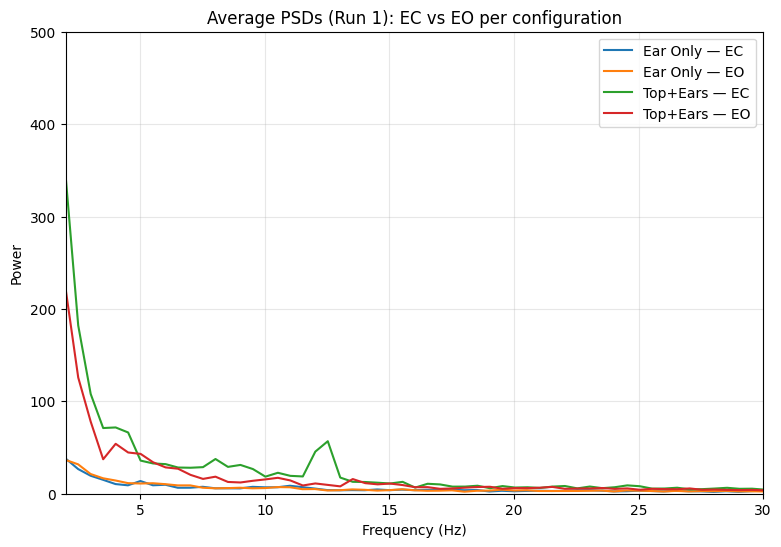

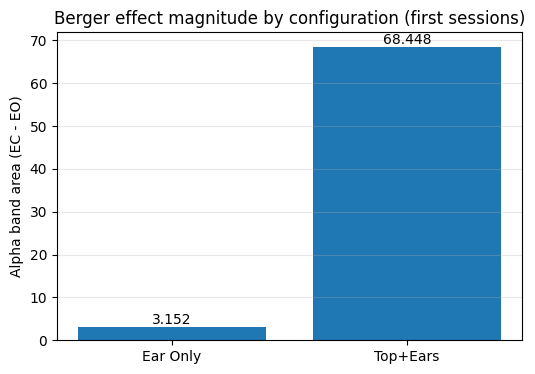

In [14]:
# Compute averages
ear_only = average_psds_across_sessions(sessions, config_label="Ear Only", verbose=False)
top_ears = average_psds_across_sessions(sessions, config_label="Top+Ears", verbose=False)

print(f"\nSessions used — Ear Only: {ear_only['n_used']}, Top+Ears: {top_ears['n_used']}")
print(f"Median fs — Ear Only: {ear_only['fs_median']:.2f} Hz, Top+Ears: {top_ears['fs_median']:.2f} Hz")

# Plot averaged PSD curves for EC vs EO per configuration
plt.figure(figsize=(9, 6))
plt.plot(ear_only['EC']['Frequency'], ear_only['EC']['Power'], label="Ear Only — EC")
plt.plot(ear_only['EO']['Frequency'], ear_only['EO']['Power'], label="Ear Only — EO")
plt.plot(top_ears['EC']['Frequency'], top_ears['EC']['Power'], label="Top+Ears — EC")
plt.plot(top_ears['EO']['Frequency'], top_ears['EO']['Power'], label="Top+Ears — EO")
plt.xlim(2, 30)
plt.ylim(0, 500)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Average PSDs (Run 1): EC vs EO per configuration")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot Berger effect magnitude (alpha 8–13 Hz: EC - EO) per configuration
configs = ["Ear Only", "Top+Ears"]
effects = [ear_only['alpha_effect'], top_ears['alpha_effect']]

plt.figure(figsize=(6, 4))
plt.bar(configs, effects)
plt.ylabel("Alpha band area (EC - EO)")
plt.title("Berger effect magnitude by configuration (first sessions)")
for i, v in enumerate(effects):
    try:
        plt.text(i, v, f"{v:.3f}", ha='center', va='bottom')
    except Exception:
        pass
plt.grid(True, axis='y', alpha=0.3)
plt.show()


=== Summary (first sessions) ===
Ear Only:  alpha_abs=2.980, alpha_dB=2.036, alpha_rel=0.0242, EC_area_1-30Hz=239.5
Top+Ears:  alpha_abs=69.538, alpha_dB=14.266, alpha_rel=0.0131, EC_area_1-30Hz=1626.7


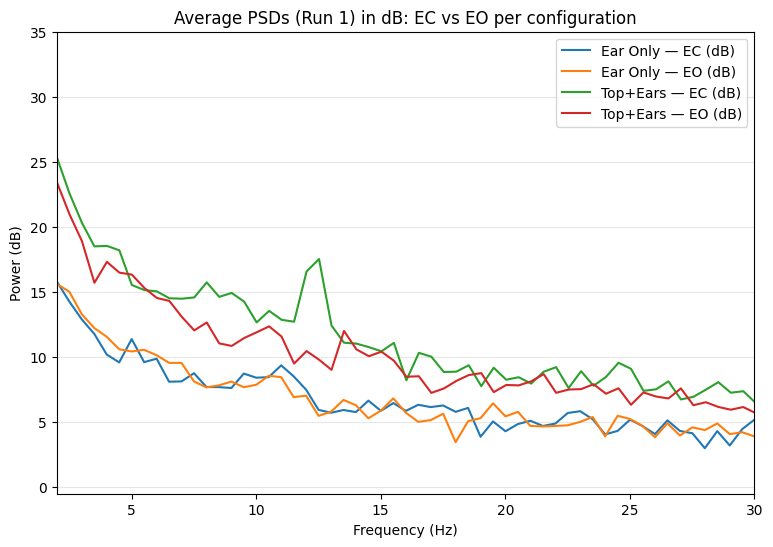

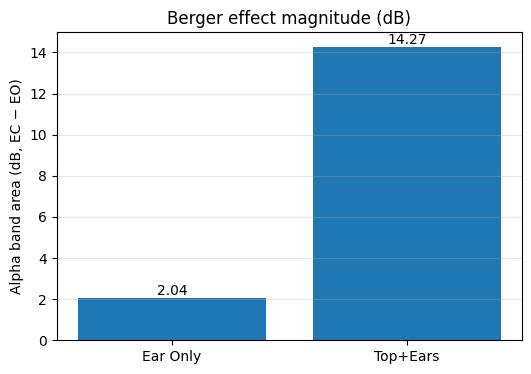

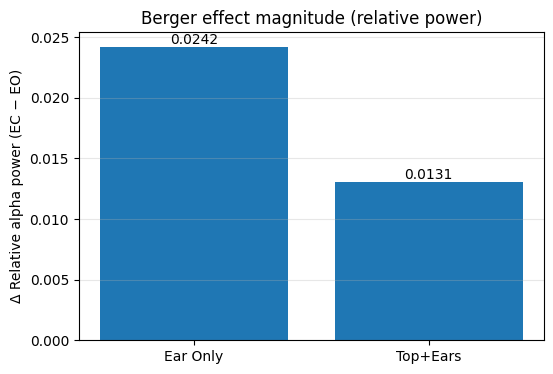

In [ ]:
def to_db(psd_df, power_col='Power'):
    """Return a copy where 'Power' is converted to dB (10*log10)."""
    df = psd_df.copy()
    # Protect against log of zero
    p = np.maximum(df[power_col].to_numpy(dtype=float), 1e-12)
    df['Power'] = 10.0 * np.log10(p)
    return df[['Frequency', 'Power']]

def band_area(psd_df, lo, hi, power_col='Power'):
    """Integrate power in [lo, hi] using trapezoid rule."""
    f = psd_df['Frequency'].to_numpy(dtype=float)
    P = psd_df[power_col].to_numpy(dtype=float)
    m = (f >= lo) & (f <= hi)
    if m.sum() < 2:
        return np.nan
    return float(np.trapz(P[m], f[m]))

def rel_band_power(psd_df, lo, hi, power_col='Power'):
    """Relative band power = area(lo..hi) / area(total)."""
    f = psd_df['Frequency'].to_numpy(dtype=float)
    P = psd_df[power_col].to_numpy(dtype=float)
    if len(f) < 2:
        return np.nan
    band = band_area(psd_df, lo, hi, power_col=power_col)
    total = float(np.trapz(P, f))
    return (band / total) if total > 0 else np.nan

# Convert to dB
ear_only_db = {'EC': to_db(ear_only['EC']), 'EO': to_db(ear_only['EO'])}
top_ears_db = {'EC': to_db(top_ears['EC']), 'EO': to_db(top_ears['EO'])}

# Compute absolute, dB, and relative Berger effects (alpha 8–13 Hz)
def alpha_metrics(pair):
    abs_eff = band_area(pair['EC'], 8, 13) - band_area(pair['EO'], 8, 13)
    db_eff  = band_area(to_db(pair['EC']), 8, 13) - band_area(to_db(pair['EO']), 8, 13)
    rel_eff = rel_band_power(pair['EC'], 8, 13) - rel_band_power(pair['EO'], 8, 13)
    return abs_eff, db_eff, rel_eff

eo_abs, eo_db, eo_rel = alpha_metrics(ear_only)
te_abs, te_db, te_rel = alpha_metrics(top_ears)

# Quick broadband scale check (1–30 Hz EC area)
eo_broad = band_area(ear_only['EC'], 1, 30)
te_broad = band_area(top_ears['EC'], 1, 30)

print("=== Summary (first sessions) ===")
print(f"Ear Only:  alpha_abs={eo_abs:.3f}, alpha_dB={eo_db:.3f}, alpha_rel={eo_rel:.4f}, EC_area_1-30Hz={eo_broad:.1f}")
print(f"Top+Ears:  alpha_abs={te_abs:.3f}, alpha_dB={te_db:.3f}, alpha_rel={te_rel:.4f}, EC_area_1-30Hz={te_broad:.1f}")

# Plots in dB and bar charts for the new metrics
# PSDs in dB
plt.figure(figsize=(9, 6))
plt.plot(ear_only_db['EC']['Frequency'], ear_only_db['EC']['Power'], label="Ear Only — EC (dB)")
plt.plot(ear_only_db['EO']['Frequency'], ear_only_db['EO']['Power'], label="Ear Only — EO (dB)")
plt.plot(top_ears_db['EC']['Frequency'], top_ears_db['EC']['Power'], label="Top+Ears — EC (dB)")
plt.plot(top_ears_db['EO']['Frequency'], top_ears_db['EO']['Power'], label="Top+Ears — EO (dB)")
plt.xlim(2, 30)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.title("Average PSDs (Run 1) in dB: EC vs EO per configuration")
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# Berger effect (alpha area) in dB
plt.figure(figsize=(6, 4))
plt.bar(["Ear Only", "Top+Ears"], [eo_db, te_db])
plt.ylabel("Alpha band area (dB, EC − EO)")
plt.title("Berger effect magnitude (dB)")
for i, v in enumerate([eo_db, te_db]):
    try: plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')
    except: pass
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# Berger effect (relative alpha power)
plt.figure(figsize=(6, 4))
plt.bar(["Ear Only", "Top+Ears"], [eo_rel, te_rel])
plt.ylabel("Δ Relative alpha power (EC − EO)")
plt.title("Berger effect magnitude (relative power)")
for i, v in enumerate([eo_rel, te_rel]):
    try: plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')
    except: pass
plt.grid(True, axis='y', alpha=0.3)
plt.show()


##### Interpretation: 
Okay we can see that intrestingly the absolut berger effect is more visible in the dry electrode setup (even when comparing only electrodes that are present in both setups).

Even when looking at the effect in dB it is more visible in the dry electrodes.\
However, when we look at relative power, this is where we can see the effect more present in the wet electrodes.

___
### ASSR Evaluation: 
We will now look into the Auditory Steady State Response. 
Here multiple things could be interesting: 
1) ASSR within subject over the three sessions: 
2) ASSR between subjects

In [16]:
def _get_fs_from_context(eeg_df, default=None):
    """Return sampling rate from global `fs`, else infer from Time column, else `default`."""
    fs_val = globals().get("fs", None)
    if isinstance(fs_val, (int, float)) and fs_val > 0:
        return float(fs_val)
    if "Time" in eeg_df.columns:
        t = eeg_df["Time"].to_numpy()
        t = t[np.isfinite(t)]
        if t.size >= 2:
            dt = np.median(np.diff(t))
            if dt > 0:
                return float(1.0 / dt)
    if default is not None:
        return float(default)
    raise ValueError("Sampling rate not found. Define a global `fs` or include a 'Time' column.")

def _welch_psd(signal, fs, nperseg_s=2.0, overlap=0.5):
    nperseg = max(16, int(nperseg_s * fs))
    noverlap = int(overlap * nperseg)
    f, Pxx = welch(signal, fs=fs, window=get_window("hann", nperseg),
                   nperseg=nperseg, noverlap=noverlap, detrend="constant", scaling="density")
    return f, Pxx

def assr_snr_db_from_psd(f, Pxx, f0=40.0, sig_half_bw=0.5, noise_half_bw=4.0, guard=0.5):
    """SNR(dB) at f0 from PSD using sidebands as noise."""
    f = np.asarray(f); Pxx = np.asarray(Pxx)
    sig_mask = (f >= (f0 - sig_half_bw)) & (f <= (f0 + sig_half_bw))
    n1_mask  = (f >= (f0 - noise_half_bw)) & (f < (f0 - guard))
    n2_mask  = (f >  (f0 + guard)) & (f <= (f0 + noise_half_bw))
    if not np.any(sig_mask) or (not np.any(n1_mask) and not np.any(n2_mask)):
        return np.nan
    Psig = np.nanmean(Pxx[sig_mask])
    if np.any(n1_mask) and np.any(n2_mask):
        Pn = np.nanmean(np.concatenate([Pxx[n1_mask], Pxx[n2_mask]]))
    else:
        Pn = np.nanmean(Pxx[n1_mask] if np.any(n1_mask) else Pxx[n2_mask])
    if not np.isfinite(Psig) or not np.isfinite(Pn) or Pn <= 0:
        return np.nan
    return float(10.0 * np.log10(Psig / Pn))

def sliding_assr_snr(eeg_df, channel, fs=None, f0=40.0, window_s=2.0, step_s=0.5,
                     sig_half_bw=0.5, noise_half_bw=4.0, guard=0.5):
    """Sliding-window ASSR SNR(dB) for a single channel. Returns DataFrame with start_s, end_s, snr_db."""
    if fs is None:
        fs = _get_fs_from_context(eeg_df)
    x = eeg_df.loc[eeg_df["Channel"] == channel, "mV"].to_numpy()
    nwin = max(1, int(window_s * fs))
    nstep = max(1, int(step_s * fs))
    out = []
    for start in range(0, max(0, x.size - nwin + 1), nstep):
        seg = x[start:start + nwin]
        if seg.size < nwin:
            break
        f, Pxx = _welch_psd(seg, fs, nperseg_s=min(window_s, 4.0), overlap=0.5)
        snr = assr_snr_db_from_psd(f, Pxx, f0=f0, sig_half_bw=sig_half_bw,
                                   noise_half_bw=noise_half_bw, guard=guard)
        out.append({"start_s": start / fs, "end_s": (start + nwin) / fs, "snr_db": snr})
    return pd.DataFrame(out)

def detect_best_assr_window(eeg_df, channels=None, fs=None, f0=40.0, window_s=2.0, step_s=0.5,
                            aggregate="median", min_len_windows=2, dynamic_thresh_db=None):
    """
    Detect an ASSR interval without timestamps by sliding-window SNR across channels.
    Returns dict with {start_s, end_s, snr_series(DataFrame), chosen_idx}.
    """
    if fs is None:
        fs = _get_fs_from_context(eeg_df)
    if channels is None:
        channels = list(eeg_df["Channel"].unique())
    snr_tables = []
    for ch in channels:
        df = sliding_assr_snr(eeg_df, ch, fs=fs, f0=f0, window_s=window_s, step_s=step_s)
        df = df.rename(columns={"snr_db": f"snr_{ch}"})
        snr_tables.append(df)
    snr_df = snr_tables[0]
    for df in snr_tables[1:]:
        snr_df = snr_df.merge(df, on=["start_s", "end_s"], how="inner")
    vals = snr_df.filter(regex=r"^snr_")
    snr_df["snr_agg"] = vals.median(axis=1, skipna=True) if aggregate == "median" else vals.mean(axis=1, skipna=True)
    if dynamic_thresh_db is None:
        idx = int(np.nanargmax(snr_df["snr_agg"].to_numpy()))
        return {"start_s": float(snr_df.loc[idx, "start_s"]), "end_s": float(snr_df.loc[idx, "end_s"]),
                "snr_series": snr_df, "chosen_idx": idx}
    thr = np.nanmedian(snr_df["snr_agg"]) + float(dynamic_thresh_db)
    mask = snr_df["snr_agg"].to_numpy() >= thr
    best_len, best_start = 0, None
    cur_len, cur_start = 0, None
    for i, m in enumerate(mask):
        if m:
            if cur_len == 0:
                cur_start = i
            cur_len += 1
        else:
            if cur_len > best_len:
                best_len, best_start = cur_len, cur_start
            cur_len, cur_start = 0, None
    if cur_len > best_len:
        best_len, best_start = cur_len, cur_start
    if best_start is None:
        idx = int(np.nanargmax(snr_df["snr_agg"].to_numpy()))
        return {"start_s": float(snr_df.loc[idx, "start_s"]), "end_s": float(snr_df.loc[idx, "end_s"]),
                "snr_series": snr_df, "chosen_idx": idx}
    end_idx = best_start + max(min_len_windows, best_len) - 1
    return {"start_s": float(snr_df.loc[best_start, "start_s"]), "end_s": float(snr_df.loc[end_idx, "end_s"]),
            "snr_series": snr_df, "chosen_idx": best_start}

# ---------- Plotting ----------

def plot_assr_raw_and_psd(eeg_df, start_s, end_s, fs=None, channel=None, f0=40.0):
    """Plot raw segment and its PSD for the detected ASSR window."""
    if fs is None:
        fs = _get_fs_from_context(eeg_df)
    if channel is None:
        channel = eeg_df["Channel"].unique()[0]
    mask = (eeg_df["Channel"] == channel)
    x = eeg_df.loc[mask, "mV"].to_numpy()
    n = x.size
    t = np.arange(n) / fs
    i0 = max(0, int(start_s * fs))
    i1 = min(n, int(end_s * fs))
    seg_t = t[i0:i1]
    seg_x = x[i0:i1]

    plt.figure(figsize=(10, 3))
    plt.plot(seg_t - seg_t[0], seg_x)
    plt.title(f"Raw {channel} during detected ASSR window ({start_s:.2f}-{end_s:.2f}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    f, Pxx = _welch_psd(seg_x, fs, nperseg_s=min(4.0, max(1.0, end_s - start_s)), overlap=0.5)
    plt.figure(figsize=(8, 4))
    plt.semilogy(f, Pxx)
    plt.axvline(f0, linestyle="--")
    plt.xlim(1, 90)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (units^2/Hz)")
    plt.title(f"PSD {channel} during detected ASSR window")
    plt.tight_layout()
    plt.show()

    snr_db = assr_snr_db_from_psd(f, Pxx, f0=f0)
    print(f"Estimated ASSR SNR for {channel}: {snr_db:.2f} dB")

# ---------- Convenience driver ----------

def run_assr_view(eeg_df, channels_to_use=None, f0=40.0):
    """Detect best ASSR window and plot raw+PSD for the best channel."""
    det = detect_best_assr_window(eeg_df, channels=channels_to_use, f0=f0,
                                  window_s=2.0, step_s=0.5, aggregate="median",
                                  dynamic_thresh_db=2.0)
    print(f"Detected ASSR window: {det['start_s']:.2f}s to {det['end_s']:.2f}s")
    fs_loc = _get_fs_from_context(eeg_df)
    best_ch, best_snr = None, -np.inf
    for ch in (channels_to_use if channels_to_use else eeg_df['Channel'].unique()):
        df_snr = sliding_assr_snr(eeg_df, ch, fs=fs_loc, f0=f0, window_s=2.0, step_s=0.5)
        overlap = (df_snr['start_s'] <= det['start_s']) & (df_snr['end_s'] >= det['end_s'])
        if overlap.any():
            snr_val = df_snr.loc[overlap, 'snr_db'].iloc[0]
            if snr_val > best_snr:
                best_snr, best_ch = snr_val, ch
    print(f"Channel selected for visualization: {best_ch} (SNR≈{best_snr:.2f} dB)")
    plot_assr_raw_and_psd(eeg_df, det['start_s'], det['end_s'], fs=fs_loc, channel=best_ch, f0=f0)
    return det


In [17]:
det = run_assr_view(eeg, channels_to_use=chans if 'chans' in globals() else None, f0=40.0)

KeyError: 'Channel'